# The Poisson-Bolzman Distribution

In order to understand lubrication better, we simulate thin layers of lubricant on a metallic surface, solvated in water.
Different structures of lubricant films are created by varying parameters like their concentration and the charge of the surface.
The lubricant is somewhat solvable in water, thus parts of the film will diffuse into the bulk water.
Lubricant molecules are charged, and their distribution is roughly exponential.

As simplification, we  first create a solution of ions (Na+, purple; Cl-, green) in water (not shown).
![pic](https://i.ibb.co/Yh8DxVM/showpicture.png)

Close to the positively charged metallic surface, the electric potential (red) will be highest, falling off exponentially when further away.
This potential attracts negatively charged Chlorine ions, and pushes positively charged Natrium ions away, resulting in a higher (lower) concentration of Clorine (Natrium) near the surface.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy.constants as sc
import matplotlib.pyplot as plt

# Sampling and plotting
from continuous2discrete import generate_structure 
from continuous2discrete import plot_dist
from continuous2discrete import get_histogram
from IPython.display import Image

In [3]:
# Physical distribution generation
from continuous2discrete.poisson_bolzmann_distribution import debye 
from continuous2discrete.poisson_bolzmann_distribution import gamma
from continuous2discrete.poisson_bolzmann_distribution import charge_density
from continuous2discrete.poisson_bolzmann_distribution import potential

np.random.seed(74)

To calculate this, we first need to find out how ions are distributed in solution.
A good description of the concentration of our ion species, $c_{Na^+}$, is given by the solution to the Poisson-Bolzmann equation:

$
\begin{align}
\rho_{Na^+}(z) &= \rho_{Na^+}(\infty) e^{-e \Psi(z)/k_B T}\\
\Psi(z) &= \frac{2k_B T}{e} \log\Big(\frac{1 + \gamma e^{-\kappa z}}{1- \gamma e^{-\kappa z}}\Big) 
        \approx \frac{4k_B T}{e} \gamma e^{-\kappa z} \\
\gamma &= \tanh(\frac{e\Psi(0)}{4k_B T})\\
\kappa &= 1/\lambda_D\\
\lambda_D &= \Big(\frac{\epsilon \epsilon_0 k_B T}{\sum_{i} \rho_i(\infty) e^2 z_i^2} \Big)^\frac{1}{2} [m^{-1}]
\end{align}
$

With:
* $z$: Distance from the double layer
* $\Psi(0)$: Potential at the surface
* $\Psi(z)$: Potential in the solution
* $k_B$: Bolzmann Constant
* $T$: Temperature [Kelvin]
* $e$: Elemental Charge (or Euler's constant when exponentiated)
* $\gamma$: Term from Gouy-Chapmann theory
    * $\gamma \rightarrow 1$ for high potentials
    * $\Psi(z) \approx \Psi_0 e^{-\kappa z}$ for low potentials $\Psi(0) \approx 0$
* $\lambda_D$: Debye Length (34.0 nm for NaCl, 10^-4 M, 25°C)
* $\rho_{Na^+}$: Concentration of Natrium ions
* $\rho_{Na^+}(\infty)$: Bulk Natrium concentration (at infinity, where the solution is homogeneous)
* $\epsilon$: Permittivity of the solution
* $\epsilon_0$: Electric constant aka Vacuum permittivity
* $z_i$: Charge of species i 


These equations are implemented in `poisson_bolzmann_distribution.py`

Debye Length of 10^-4 M saltwater: 30.52 nm (Target: 30.4 nm)


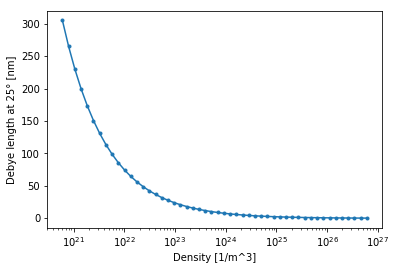

In [14]:
default_density = sc.Avogadro * 1000 * 10**-4
rho = {'Na': default_density, 'Cl': default_density} 
charge = {'Na': 1, 'Cl': -1}
deb = debye(rho_bulk=rho, charge=charge) * 10**9
print('Debye Length of 10^-4 M saltwater: {} nm (Target: 30.4 nm)'.format(round(deb, 2)))

density = np.logspace(-6, 0, 50) * sc.Avogadro * 1000
debyes = [debye(rho_bulk={'Na': d, 'Cl': d}, charge=charge) * 10**9 for d in density]

plt.xlabel('Density [1/m^3]')
plt.ylabel('Debye length at 25° [nm]')
plt.semilogx(density, debyes, marker='.')
plt.show()

The debye length depends on the concentration of ions in solution, at low concentrations it becomes large. We can reproduce literature debye lengths with our function, so everything looks good.

## Gamma Function

Next we calculate the gamma function $\gamma = \tanh(\frac{e\Psi(0)}{4k_B T})$

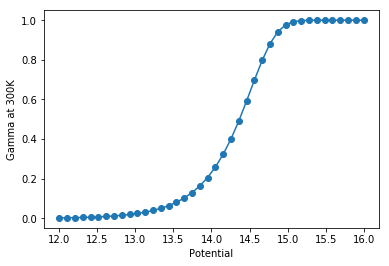

In [15]:
x = np.linspace(12, 16, 40)
gammas = [gamma(10 ** i, 300) for i in x]
plt.xlabel('Potential')
plt.ylabel('Gamma at 300K')
plt.plot(x, gammas, marker='o')
plt.show()

Which looks as expected, but we have no values to compare it against.

## Potential

We plug these two functions into the expression for the potential

$\Psi(z) = \frac{2k_B T}{e} \log\Big(\frac{1 + \gamma e^{-\kappa z}}{1- \gamma e^{-\kappa z}}\Big) 
        \approx \frac{4k_B T}{e} \gamma e^{-\kappa z}$

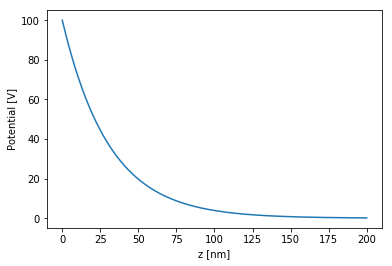

In [16]:
z = np.linspace(0, 2*10**-7, 10000)
density = sc.Avogadro * 1000 * 10**-4
rho = {'Na': density, 'Cl':density} 
charge = {'Na': 1, 'Cl': -1}
pot_0 = 100
psi = [potential(location=loc, rho_bulk=rho, charge=charge, surface_potential=pot_0) for loc in z]
plt.xlabel('z [nm]')
plt.ylabel('Potential [V]')
plt.plot(z*10**9, psi, marker='')
plt.show()

The potential is smooth and looks roughly exponential. Everything good so far.

## Charge density

Now we obtain the charge density $\rho$ from the potential $\Psi$ via

$\rho_{Na^+}(z) = \rho_{Na^+}(\infty) e^{-e \Psi(z)/k_B T}$

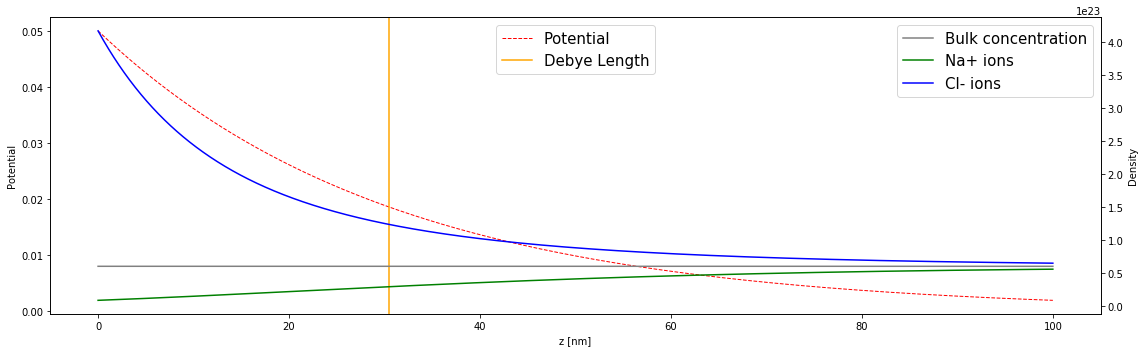

In [17]:
z = np.linspace(0, 100*10**-9, 2000)
density = sc.Avogadro * 1000 * 10**-4
rho = {'Na': density, 'Cl':density} 
charge = {'Na': 1, 'Cl': -1}
pot_0 = 0.05  # Breaks if > 1

psi = [potential(location=loc, rho_bulk=rho, charge=charge, surface_potential=pot_0) for loc in z]

rho_na = np.array([charge_density(location=loc, rho_bulk=rho, charge=charge, surface_potential=pot_0, species='Na') for loc in z])
rho_cl = np.array([charge_density(location=loc, rho_bulk=rho, charge=charge, surface_potential=pot_0, species='Cl') for loc in z])

deb = debye(rho_bulk=rho, charge=charge) * 10**9

fig, ax1 = plt.subplots(figsize=[16,5])
ax1.set_xlabel('z [nm]')
ax1.plot(z*10**9, psi, marker='', color='red', label='Potential', linewidth=1, linestyle='--')
ax1.set_ylabel('Potential')
ax1.axvline(x=deb, label='Debye Length', color='orange')

ax2 = ax1.twinx()
ax2.plot(z*10**9, [density]*len(z), label='Bulk concentration', color='grey')
ax2.plot(z*10**9, rho_na, marker='', color='green', label='Na+ ions')
ax2.plot(z*10**9, rho_cl, marker='', color='blue', label='Cl- ions')
ax2.set_ylabel('Density')

#fig.legend(loc='center')
ax2.legend(loc='best', fontsize=15)
ax1.legend(loc='upper center', fontsize=15)
fig.tight_layout()
plt.show()

The charge density behaves as expected, it interpolates between low (high) concentration and the bulk concentration within the first few debye lengths.

## Sampling
Now let's see if we can just plug our new distribution in our existing framework.

First, we need to convert the physical distribution to the format we were using so far:

In [7]:
def wrap_distribution(x, species):
    """Wrapper for na+ ions."""
    density = sc.Avogadro * 1000 * 10**-4
    rho = {'Na': density, 'Cl':density} 
    charge = {'Na': 1, 'Cl': -1}
    pot_0 = 0.05  # Breaks if > 1
    
    def call_distri(loc):
        distri = charge_density(location=loc, rho_bulk=rho, 
                                charge=charge, surface_potential=pot_0, species=species)
        return float(distri)
    
    if not np.isscalar(x):
        y = []
        for i in range(0, len(x)):
            val = call_distri(x[i])
            
            # Normalize to be 1 at x=0
            val /= call_distri(0)
            # Scale distribution to have values in [0, 0.1] for ease of sampling
            val /= 10
            y += [val]
        return np.array(y)

    # If we have only a point estimate
    val = call_distri(x)
    # Normalize to be 1 at x=0
    val /= call_distri(0)
    # Scale distribution to have values in [0, 0.1] for ease of sampling
    val /= 10    
    return val
    
def cl_distribution(x):
    return wrap_distribution(x, species='Cl')

def na_distribution(x):
    return wrap_distribution(x, species='Na')

Now we can sample the distribution of our $Na^+$ ions in z-direction.

In [8]:
x = 50 * 10**-9
z = 100 * 10**-9
box = np.array([x, x, z])
sample_size = 10000

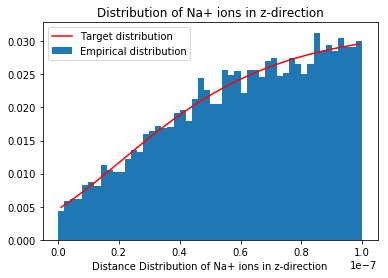

In [9]:
struc = generate_structure(distribution=na_distribution, box=box, atom_count=sample_size)
histx, histy, histz = get_histogram(struc, box=box, n_bins=51)
plot_dist(histz, 'Distribution of Na+ ions in z-direction', reference_distribution=na_distribution)

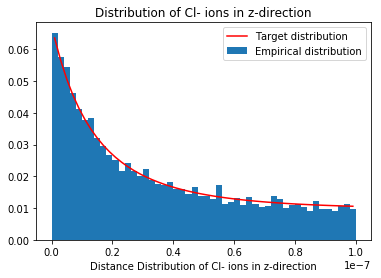

In [10]:
struc = generate_structure(distribution=cl_distribution, box=box, atom_count=sample_size)
histx, histy, histz = get_histogram(struc, box=box, n_bins=51)
plot_dist(histz, 'Distribution of Cl- ions in z-direction', reference_distribution=cl_distribution)

## Write to file
To visualize our structure, we export it to the .xyz file format, which is basically

```
ATOM_NUMBER
Optional comment
atom_type x y z
atom_type x y z
```

Avogadro expects x, y, z to be in units of $10^{-9}~m$, so we convert our salt "solution" to this unit.

Also, we use fewer atoms, just 100 for the 100x50x50 box - this will increase fluctuations with respect to the correct distribution though.

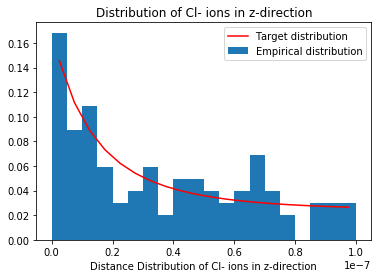

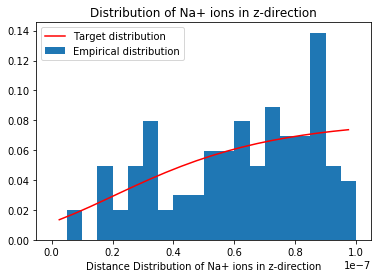

In [11]:
from generate_structure import concat_names_structs
from generate_structure import export_named_struc

cl_struc = generate_structure(distribution=cl_distribution, box=box, atom_count=100)
na_struc = generate_structure(distribution=na_distribution, box=box, atom_count=100)

concat_list = concat_names_structs(struc_list=[cl_struc, na_struc], name_list=['Cl', 'Na'])
rescaled_list = []
for line in concat_list:
    name, x, y, z = line
    x = float(x) * 10**9
    y = float(y) * 10**9
    z = float(z) * 10**9    
    rescaled_list += [[name, x, y, z]]

rescaled_list = np.array(rescaled_list)
export_named_struc(rescaled_list)

histx, histy, histz = get_histogram(cl_struc, box=box, n_bins=21)
plot_dist(histz, 'Distribution of Cl- ions in z-direction', reference_distribution=cl_distribution)

histx, histy, histz = get_histogram(na_struc, box=box, n_bins=21)
plot_dist(histz, 'Distribution of Na+ ions in z-direction', reference_distribution=na_distribution)

Now we can import the xyz file into avogadro, the visualization should look like this:

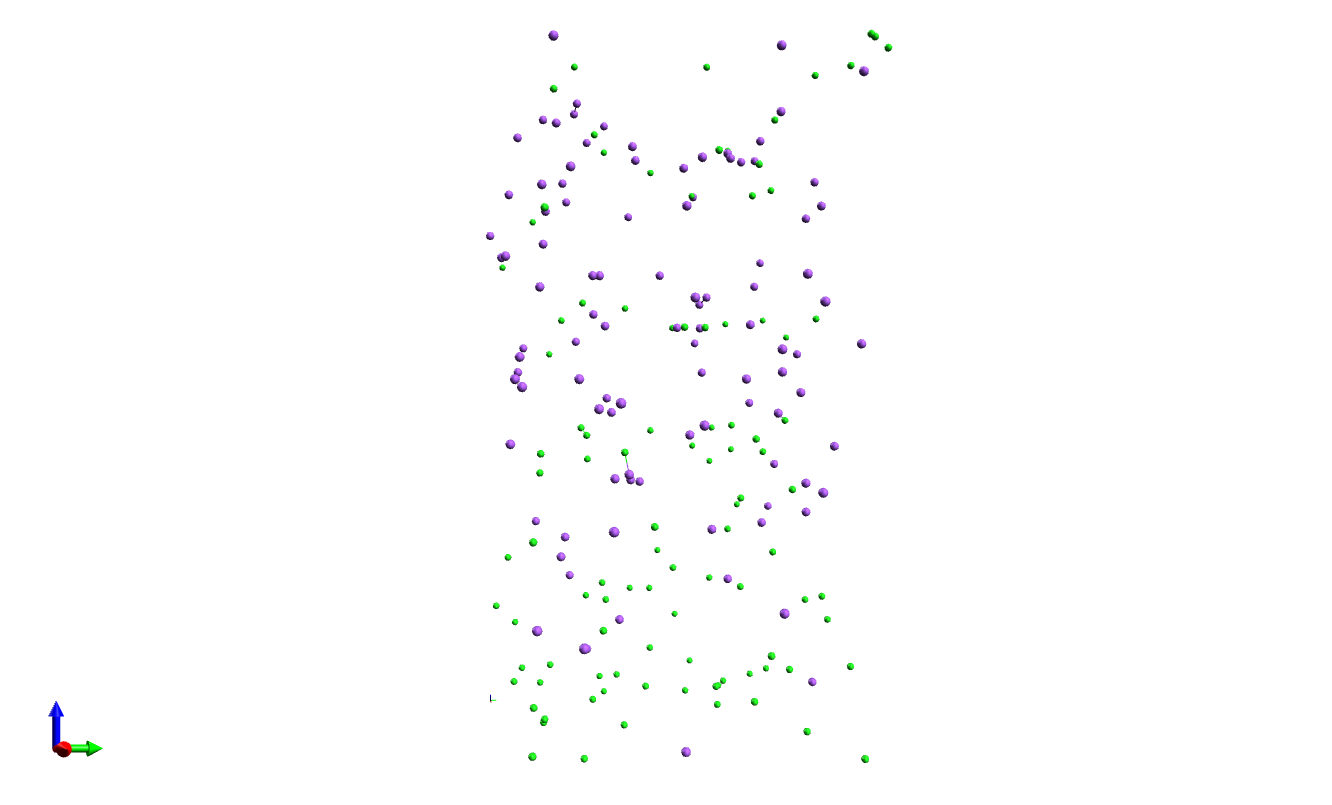

In [12]:
Image(filename='distributed_atom_structure.png') 

## General Poisson-Nernst-Planck System

In [140]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

A binary Poisson-Nernst-Planck system corresponds to the transport problem in semiconductor physics.
In this context, Debye length, charge carrier densities and potential are related as folloes

Woher kommt die Debye-Länge

$$ \lambda = \sqrt{ \frac{\varepsilon \varepsilon_0 k_B T}{q^2 n_i} }$$

als natürliche Längeneinheit des Transportptoblems?

Hier ist $n_i$ eine Referenzladungsträgerdichte, in der Regel die intrinsische Ladungsträgerdichte. 
In dem Beispiel mit $N^+NN^+$-dotiertem Halbleiter erzeugen wir durch unterschiedliches Doping an den Rändern die erhöhte Donatorendichte $N_D^+ = 10^{20} \mathrm{cm}^{-3}$ und im mitteleren Bereich "Standarddonatorendichte" $N_D = 10^{18} \mathrm{cm}^{-3}$. Nun können wir als Referenz $n_i = N_D$ wählen und die Donatorendichten als $N_D = 1 \cdot n_i$ und $N_D^+ = 100 \cdot n_i$ ausdrücken. Diese normierte Konzentration nennen wir einfach $\tilde{N}_D$: $N_D = \tilde{N}_D \cdot n_i$.

Ein ionisierter Donator trägt die Ladung $q$, ein Ladungsträger (in unserem Fall ein Elektron) trägt die Elementarladung $-q$. Die Raumladungsdichte $\rho$ in der Poissongleichung

$$ \nabla^2 \varphi = - \frac{\rho}{\varepsilon \varepsilon_0}$$

lässt sich also ganz einfach als $\rho = - (n - N_D) \cdot q = - (\tilde{n} - \tilde{N}_D) ~ n_i ~ q$ ausdrücken. 

Konventionell wird das Potential auf $u = \frac{\phi ~ q}{k_B ~ T}$ normiert. Die Poissongleichung nimmt damit die Form

$$\frac{k_B ~ T}{q} \cdot \nabla^2 u = \frac{(\tilde{n} - \tilde{N}_D) ~ n_i ~ q }{\varepsilon \varepsilon_0}$$

oder auch 

$$ \frac{\varepsilon ~ \varepsilon_0 ~ k_B ~ T}{q^2 n_i} \cdot \nabla^2 u = \lambda^2 \cdot \nabla^2 u = \tilde{n} - \tilde{N}_D$$



Poisson- und Drift-Diffusionsgleichung

$$ 
\lambda^2 \frac{\partial^2 u}{\partial x^2} = n - N_D
$$

$$ 
\frac{\partial n}{\partial t} = - D_n \ \frac{\partial}{\partial x} \left( n \ \frac{\partial u}{\partial x} - \frac{\partial n}{\partial x} \right) + R
$$

Skaliert mit [l], [t]:

$$ 
\frac{\lambda^2}{[l]^2} \frac{\partial^2 u}{\partial \tilde{x}^2} = n - N
$$

und

$$ 
\frac{1}{[t]} \frac{\partial n}{\partial \tilde{t}} = - \frac{D_n}{[l]^2} \ \frac{\partial}{\partial x} \left( n \ \frac{\partial u}{\partial x} - \frac{\partial n}{\partial x} \right) + R 
$$

oder

$$ 
\frac{\partial n}{\partial \tilde{t}} = - \tilde{D}_n \ \frac{\partial}{\partial x} \left( n \ \frac{\partial u}{\partial x} - \frac{\partial n}{\partial x} \right) +  \tilde{R} 
$$

mit 

$$ 
\tilde{D}_n = D_n \frac{[t]}{[l]^2} \Leftrightarrow [t] = [l]^2 \ \frac{ \tilde{D}_n } { D_n } 
$$
    
und

$$ \tilde{R} = \frac{n - N_D}{\tilde{\tau}}$$ 

mit $\tilde{\tau} = \tau / [t]$. 

$\tilde{\lambda} = 1$ und $\tilde{D_n} = 1$ werden mit
$[l] = \lambda$ und $[t] = \frac{\lambda^2}{D_n}$ erreicht:

## Discretization

Naive Diskretisierung (skaliert):

$$ \frac{1}{\Delta x^2} ( u_{i+1}-2u_i+u_{i-1} ) = n_i - N_i $$

$$ \frac{1}{\Delta t} ( n_{i,j+1} - n_{i,j} ) = - \frac{1}{\Delta x^2} \cdot \left[ \frac{1}{4} (n_{i+1} - n_{i-1}) (u_{i+1} - u_{i-1}) + n_i ( u_{i+1} - 2 u_i + u_{i-1} ) - ( n_{i+1} - 2 n_i + n_{i-1} ) \right] + \frac{ n_i - N_i}{ \tilde{\tau} } $$

Stationär:

$$
 u_{i+1}-2u_i+u_{i-1} - \Delta x^2 \cdot n_i + \Delta x^2 \cdot N_i = 0
$$

und

$$
  \frac{1}{4} (n_{i+1} - n_{i-1}) (u_{i+1} - u_{i-1}) + n_i ( u_{i+1} - 2 u_i + u_{i-1} ) - ( n_{i+1} - 2 n_i + n_{i-1} ) - \Delta x^2 \cdot \frac{ n_i - N_i}{ \tilde{\tau} } = 0
$$

## Newton-Iteration für gekoppeltes nicht-lineares Gleichungssystem

Idee: Löse nicht-lineares Finite-Differenzen-Gleichungssystem über Newton-Verfahren  

$$ \vec{F}(\vec{x}_{k+1}) = F(\vec{x}_k + \Delta \vec{x}_k) \approx F(\vec{x}_k) + \mathbf{J_F}(\vec{x}_k) \cdot \Delta \vec{x}_k + \mathcal{O}(\Delta x^2)$$
   
mit Unbekannter $\vec{x_k} = \{u_1^k, \dots, u_N^k, n_1^k, \dots, n_N^k\}$  und damit

$$ \Rightarrow \Delta \vec{x}_k = - \mathbf{J}_F^{-1} ~ F(\vec{x}_k)$$

wobei die Jacobi-Matrix $2N \times 2N$ Einträge

$$ \mathbf{J}_{ij}(\vec{x}_k) = \frac{\partial F_i}{\partial x_j} (\vec{x}_k) $$

besitzt, die bei jedem Iterationsschritt für $\vec{x}_k$ ausgewertet werden.
Der tatsächliche Aufwand liegt in der Invertierung der Jacobi-Matrix, um in jeder Iteration $k$ den Korrekturschritt $\Delta \vec{x}_k$ zu finden.m

$F(x)$ wird wie unten (G_steady) definiert als:

$$
 u_{i+1}-2u_i+u_{i-1} - \Delta x^2 \cdot n_i + \Delta x^2 \cdot N_i = 0
$$

und

$$
  \frac{1}{4} (n_{i+1} - n_{i-1}) (u_{i+1} - u_{i-1}) + n_i ( u_{i+1} - 2 u_i + u_{i-1} ) - ( n_{i+1} - 2 n_i + n_{i-1} ) - \Delta x^2 \cdot \frac{ n_i - N_i}{ \tilde{\tau} } = 0
$$

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [180]:
import logging

In [181]:
import matplotlib.pyplot as plt

In [182]:
logging.shutdown()

In [183]:
from continuous2discrete.poisson_nernst_planck_distribution import PoissonNernstPlanckSystem

In [184]:
standard_loglevel   = logging.INFO
standard_logformat  = ''.join(("%(asctime)s:%(name)s:%(levelname)s",
  "[ %(filename)s:%(lineno)s - %(funcName)s() ]: %(message)s"))

In [185]:
standard_loglevel   = logging.INFO
standard_logformat  = ''.join(("%(asctime)s",
  "[ %(filename)s:%(lineno)s - %(funcName)s() ]: %(message)s"))

In [205]:
logging.basicConfig(level=standard_loglevel,
                    format=standard_logformat,
                    datefmt='%m-%d %H:%M')

In [206]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [207]:
logger.handlers

[<StreamHandler stderr (DEBUG)>]

In [208]:
for h in logger.handlers: logger.removeHandler(h)

In [209]:
ch = logging.StreamHandler()

In [210]:
formatter = logging.Formatter(standard_logformat)

In [211]:
ch.setFormatter(formatter)

In [212]:
ch.setLevel(logging.INFO)

In [213]:
logger.addHandler(ch)

In [219]:
logging.info("Root logger")

2019-10-27 22:03:31,613[ <ipython-input-219-76c44f934275>:1 - <module>() ]: Root logger


In [220]:
logger.info("Root Logger")

2019-10-27 22:03:31,952[ <ipython-input-220-ba755ac4c916>:1 - <module>() ]: Root Logger


In [229]:
pnp = PoissonNernstPlanckSystem()

2019-10-27 22:11:33,422[ poisson_nernst_planck_distribution.py:375 - __init__() ]: bulk concentration c:              0.1
2019-10-27 22:11:33,424[ poisson_nernst_planck_distribution.py:376 - __init__() ]: charge number z:                     1
2019-10-27 22:11:33,425[ poisson_nernst_planck_distribution.py:377 - __init__() ]: temperature T:                   298.1
2019-10-27 22:11:33,429[ poisson_nernst_planck_distribution.py:378 - __init__() ]: domain size L:                   1e-07
2019-10-27 22:11:33,430[ poisson_nernst_planck_distribution.py:379 - __init__() ]: potential difference delta_u:        1
2019-10-27 22:11:33,431[ poisson_nernst_planck_distribution.py:380 - __init__() ]: relative permittivity eps_R:        79
2019-10-27 22:11:33,432[ poisson_nernst_planck_distribution.py:381 - __init__() ]: vacuum permittivity eps_0:     8.854e-12
2019-10-27 22:11:33,434[ poisson_nernst_planck_distribution.py:382 - __init__() ]: universal gas constant R:        8.314
2019-10-27 22:11:33,43

In [236]:
pnp.output = True

2019-10-27 22:12:56,516[ poisson_nernst_planck_distribution.py:230 - solve() ]: discretization segments N:        1000
2019-10-27 22:12:56,516[ poisson_nernst_planck_distribution.py:231 - solve() ]: grid points Ni:                   1001
2019-10-27 22:12:56,517[ poisson_nernst_planck_distribution.py:248 - solve() ]: dx:                            0.002317
2019-10-27 22:12:56,520[ poisson_nernst_planck_distribution.py:249 - solve() ]: dx2overtau:                         10
2019-10-27 22:12:56,521[ poisson_nernst_planck_distribution.py:260 - solve() ]: Left hand side Dirichlet boundary condition:  u0 =        0
2019-10-27 22:12:56,522[ poisson_nernst_planck_distribution.py:261 - solve() ]: Right hand side Dirichlet boundary condition: u1 =    38.92
2019-10-27 22:12:56,737[ poisson_nernst_planck_distribution.py:139 - newton() ]: Convergence criterion: norm(dx) < 1.00e-10
2019-10-27 22:12:56,738[ poisson_nernst_planck_distribution.py:147 - newton() ]: *** Newton solver iteration 0 ***
2019

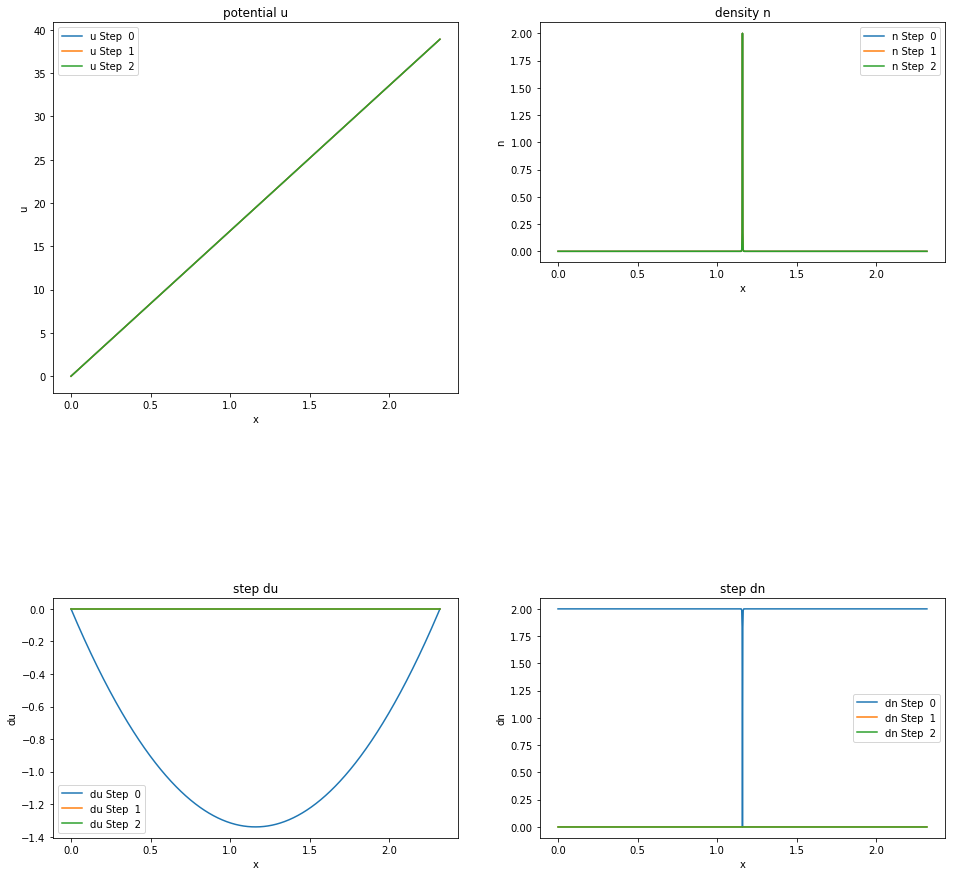

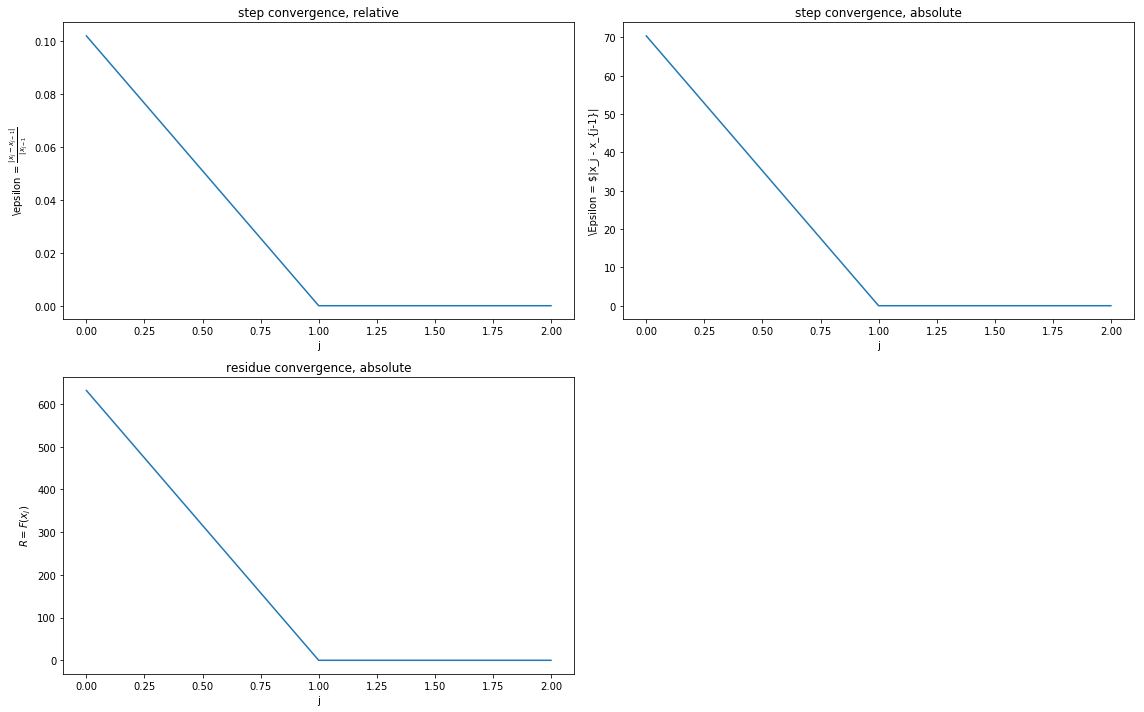

In [237]:
xij = pnp.solve()

In [238]:
xij

array([ 0.00000000e+00,  3.89154054e-02,  7.78308109e-02, ...,
        1.26217745e-29, -5.52202634e-30, -2.36658272e-30])

In [239]:
pnp.u_unit

0.025692570208532963

In [168]:
uij = xij[:pnp.Ni] * pnp.u_unit

In [169]:
nij = xij[pnp.Ni:] * pnp.c_unit

In [170]:
nij

array([-1.02551918e-30, -3.94430453e-31,  8.67746996e-31, ...,
        1.57772181e-31, -2.52435490e-30, -1.57772181e-30])

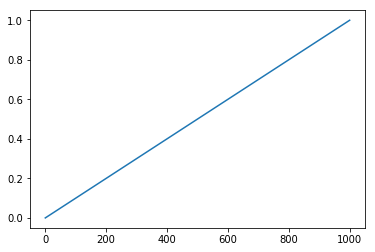

In [173]:
plt.plot(uij)

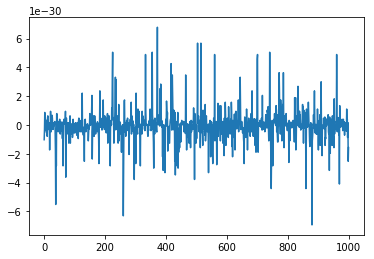

In [174]:
plt.plot(nij)